# Homework N4

### Data Preparations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings("ignore") #Who needs warnings?


df = pd.read_csv('bundesliga.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.head()

,SEASON,LEAGUE,DATE,HOMETEAM,AWAYTEAM,FTSC,FTHG,FTAG,FTTG
0,1994,Bundesliga 1,1993-08-07,Bayern Munich,Freiburg,3-1,3,1,4
1,1994,Bundesliga 1,1993-08-07,Dortmund,Karlsruhe,2-1,2,1,3
2,1994,Bundesliga 1,1993-08-07,Duisburg,Leverkusen,2-2,2,2,4
3,1994,Bundesliga 1,1993-08-07,FC Koln,Kaiserslautern,0-2,0,2,2
4,1994,Bundesliga 1,1993-08-07,Hamburg,Nurnberg,5-2,5,2,7


## Part 1: Part 1: Trend Analysis

### 1. Analyze trend of goals per season. For example total goals per match, average goals per match.

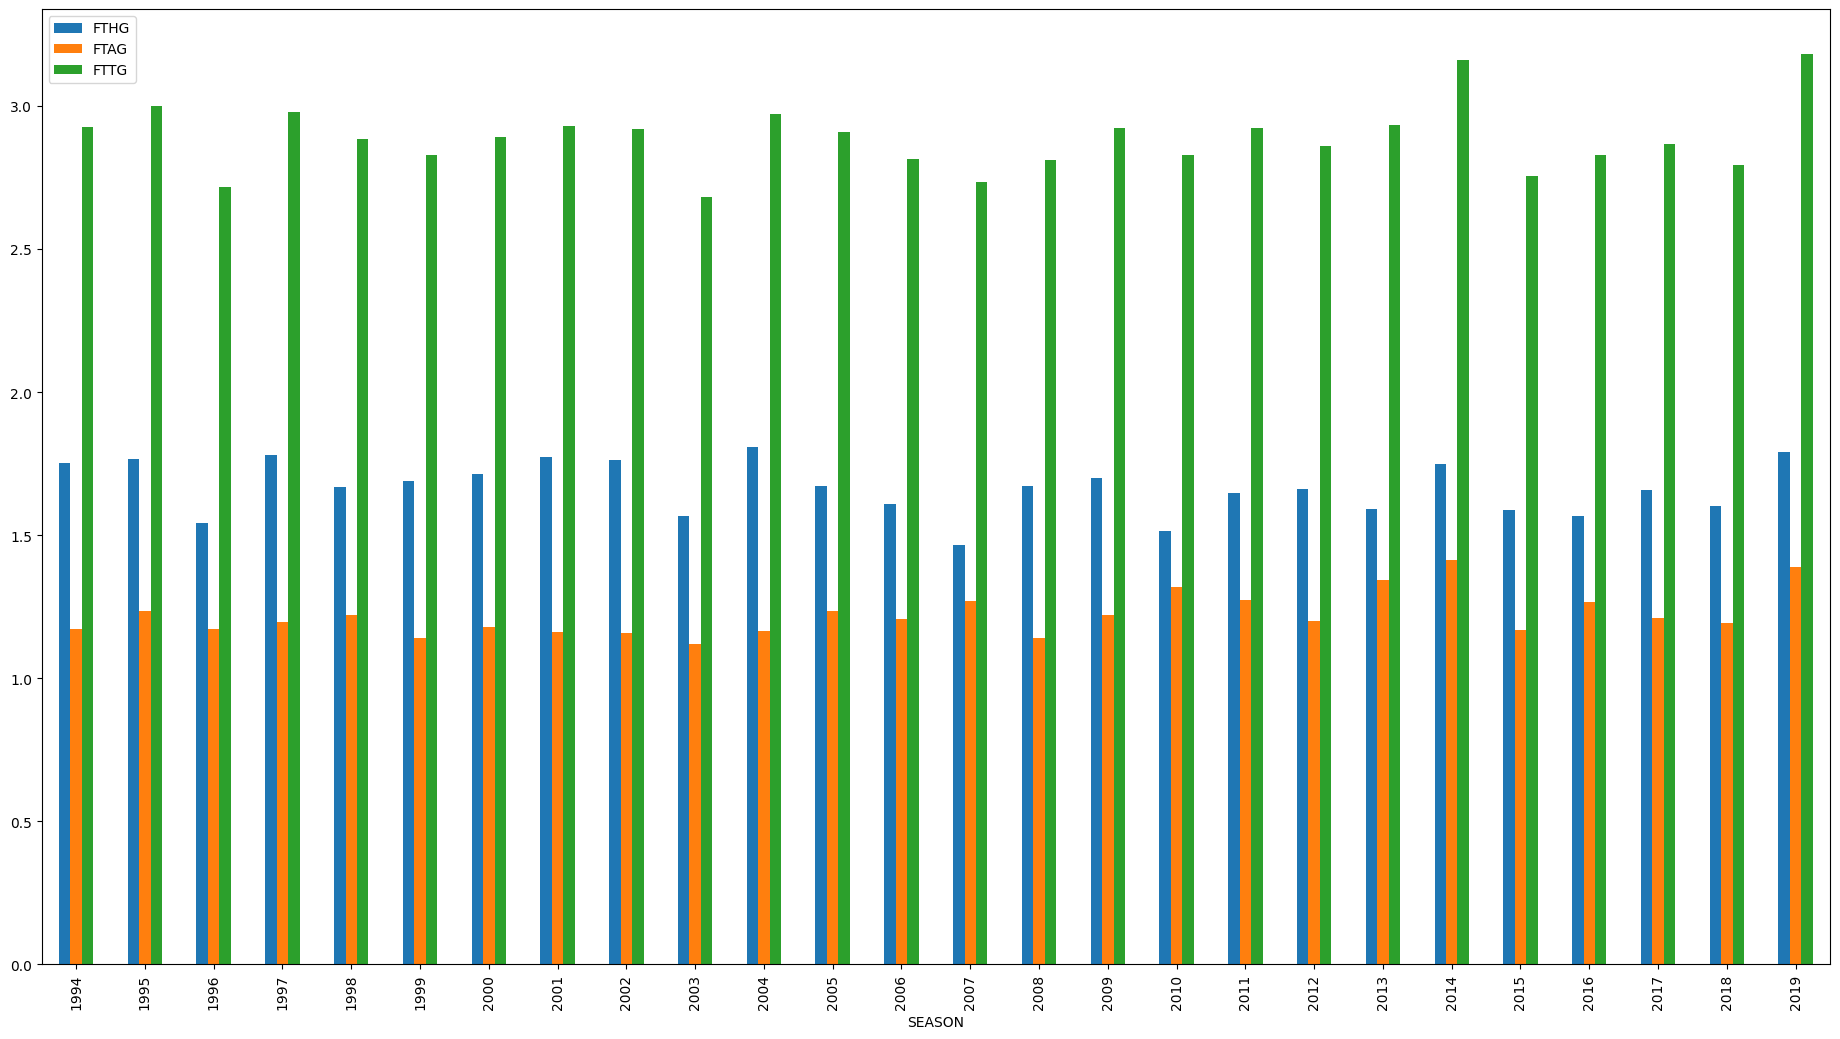

In [2]:
fig, ax = plt.subplots()
df.groupby('SEASON').mean('FTTG').plot(y=['FTHG','FTAG','FTTG'], kind='bar', ax=ax)
fig.set_size_inches(18.5, 10.5)
plt.tight_layout()
plt.show();

As we can in terms of average goals Home Teams have a very clear advantage and they score about one extra goal in average. There does not seem to be any significant pattern regarding the number of goals they seem to be random.  

### 2. Goal Distribution Per Season. Use appropriate type of graphs for goals per match, year-wise. Colorcode by whether average is above or below 2.5 (over/under bet threshold).

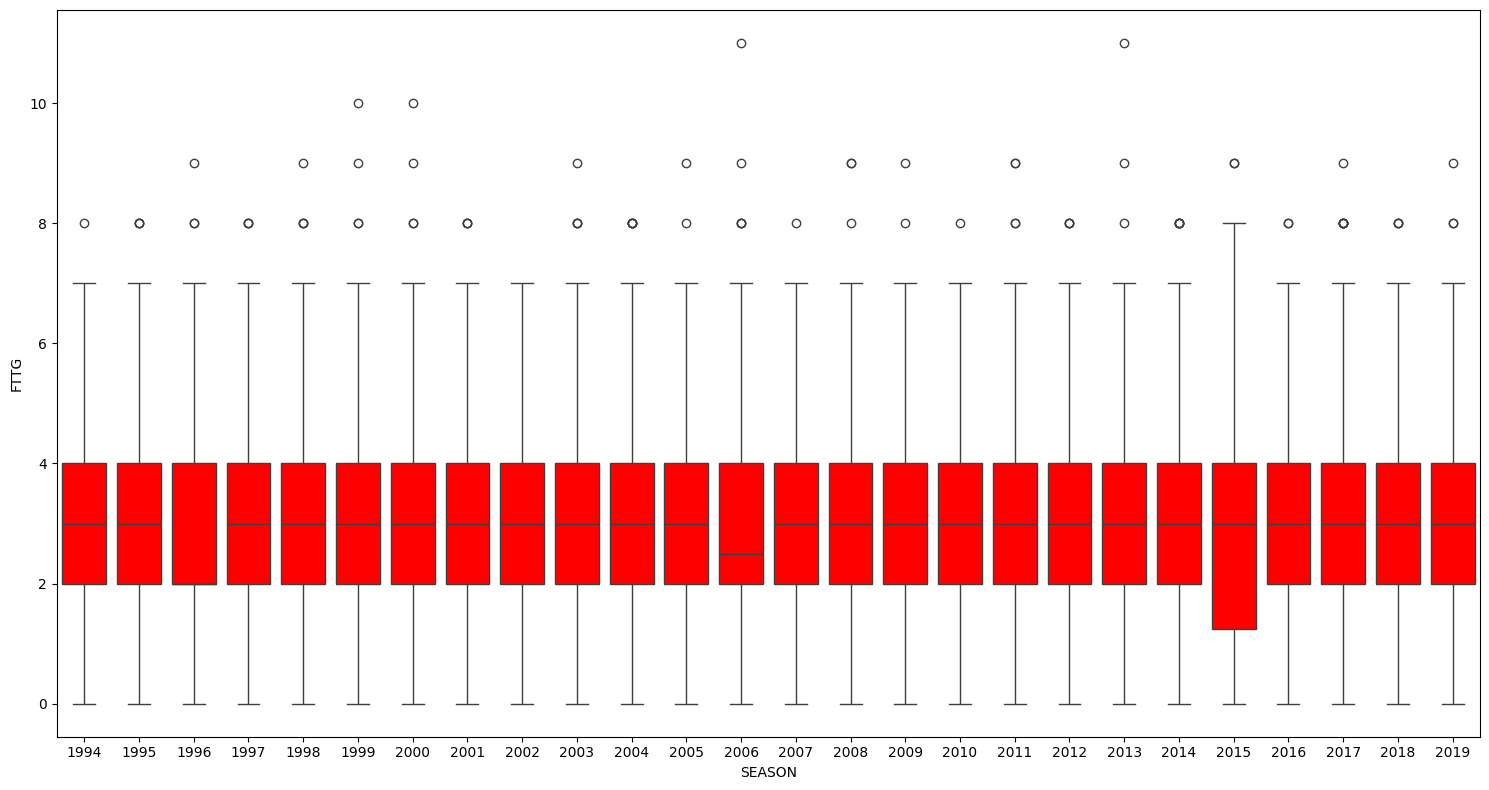

In [3]:
avg = df.groupby('SEASON').mean('FTTG').reset_index()
fig, ax = plt.subplots()
boxplot  = sns.boxplot(x = 'SEASON', y='FTTG', ax=ax, data=df,  patch_artist=True)

for i, box in enumerate(boxplot.patches):
    season = df['SEASON'].unique()[i]
    avg_value = avg.loc[avg['SEASON'] == season, 'FTTG'].values[0]
    if avg_value > 2.5:
        box.set_facecolor('red')
    else:
        box.set_facecolor('blue')  

fig.set_size_inches(15, 8)
plt.tight_layout()
plt.show();

### 3. Create line charts for each season. Visualize trend of goals for each team that played in that season. Highlight only Bayern Munchen with red color. Rest should be gray. Add appropriate title that will contain information about season and total scored goals. Add footnote mentioning total number of goals scored by Bayern Munchen for that season. Save all graphs in pdf.

In [4]:
away = df[['SEASON', 'DATE', 'AWAYTEAM', 'FTAG']]
home = df[['SEASON', 'DATE', 'HOMETEAM', 'FTHG']]

away.rename(columns={'AWAYTEAM': 'TEAM', 'FTAG': 'GOALS'}, inplace=True)
home.rename(columns={'HOMETEAM': 'TEAM', 'FTHG': 'GOALS'}, inplace=True)
team_matches = pd.concat([home,away])
team_matches.sort_values('DATE')
pdf_filename = "goals_per_season.pdf"

with PdfPages(pdf_filename) as pdf:
    for season in team_matches['SEASON'].unique():
        plt.figure(figsize=(10, 6))
        subset = team_matches[team_matches['SEASON'] == season]
        for team in subset['TEAM']:
            subsubset = subset[subset['TEAM'] == team]
            sns.lineplot(x='DATE', y='GOALS', data=subsubset, color='red' if team == 'Bayern Munich' else 'grey', linewidth = 2 if team == 'Bayern Munich' else 0.2, alpha = 1 if team == 'Bayern Munich' else 0.5)
            
        plt.title(f'{season} Season (Total Goals -> {subset['GOALS'].sum()})', fontsize=14)
        plt.xlabel('Date')
        plt.ylabel('Number of Goals')
        plt.figtext(0.65, 0.01, f'Total Goals by Bayern Munich: {subset[subset['TEAM'] == 'Bayern Munich']['GOALS'].sum()}')
        pdf.savefig()
        plt.close()  


print(f"PDF file '{pdf_filename}' has been created successfully!")

PDF file 'goals_per_season.pdf' has been created successfully!


## Part 2: Home Advantage Deconstructed

### 1. Create Heatmap of Home vs. Away Wins per Team per Season

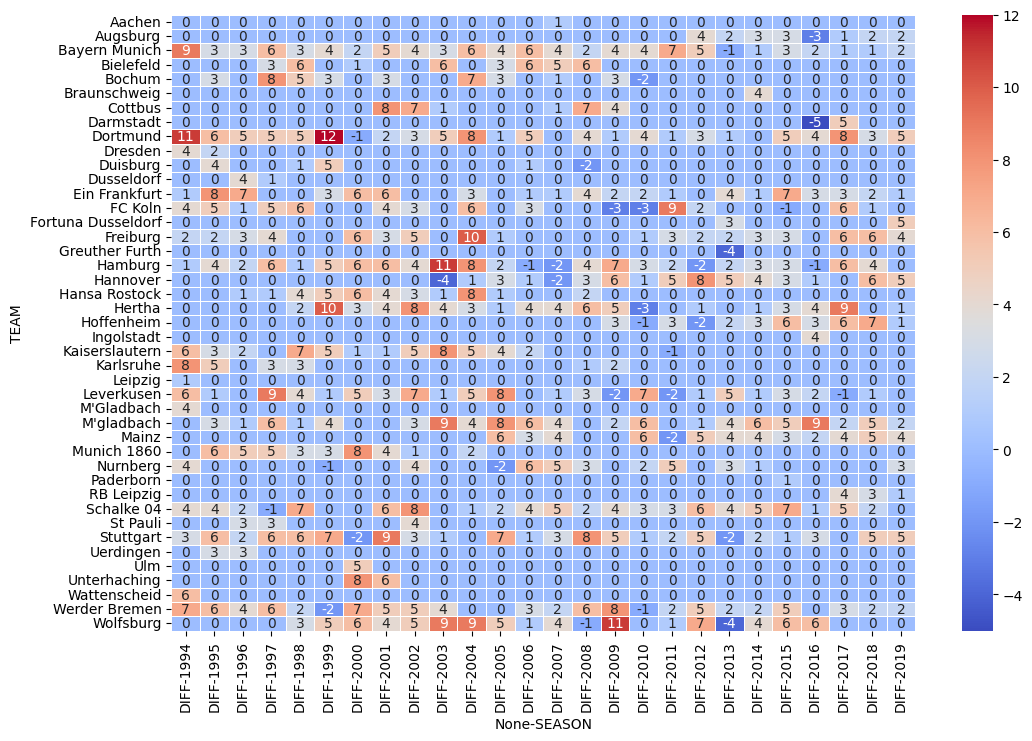

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df['HOME_WIN'] = (df['FTHG'] > df['FTAG']).astype(int)  
df['AWAY_WIN'] = (df['FTAG'] > df['FTHG']).astype(int)  

home_wins = df.groupby(['SEASON', 'HOMETEAM'])['HOME_WIN'].sum().reset_index()
away_wins = df.groupby(['SEASON', 'AWAYTEAM'])['AWAY_WIN'].sum().reset_index()

home_wins.rename(columns={'HOMETEAM': 'TEAM'}, inplace=True)
away_wins.rename(columns={'AWAYTEAM': 'TEAM'}, inplace=True)


win_counts = pd.merge(home_wins, away_wins, on=['SEASON', 'TEAM'], how='outer').fillna(0)
win_counts['DIFF'] = win_counts['HOME_WIN'] - win_counts['AWAY_WIN']
#win_counts = win_counts[['SEASON','TEAM','DIFF']]
heatmap_data = win_counts.pivot(index='TEAM', columns='SEASON', values=['DIFF']).fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.0f', linewidths=0.5);

This is a heatmap of the difference of away wins from home wins per season. The 0s are either no games that season or same number of home wins as away wins. As we can see there are more positive numbers than negative numbers meaning generally teams have more home wins rather than away wins.

### 2. Point Differential Density: Create visualizations that will show difference per team for home and away game wins.

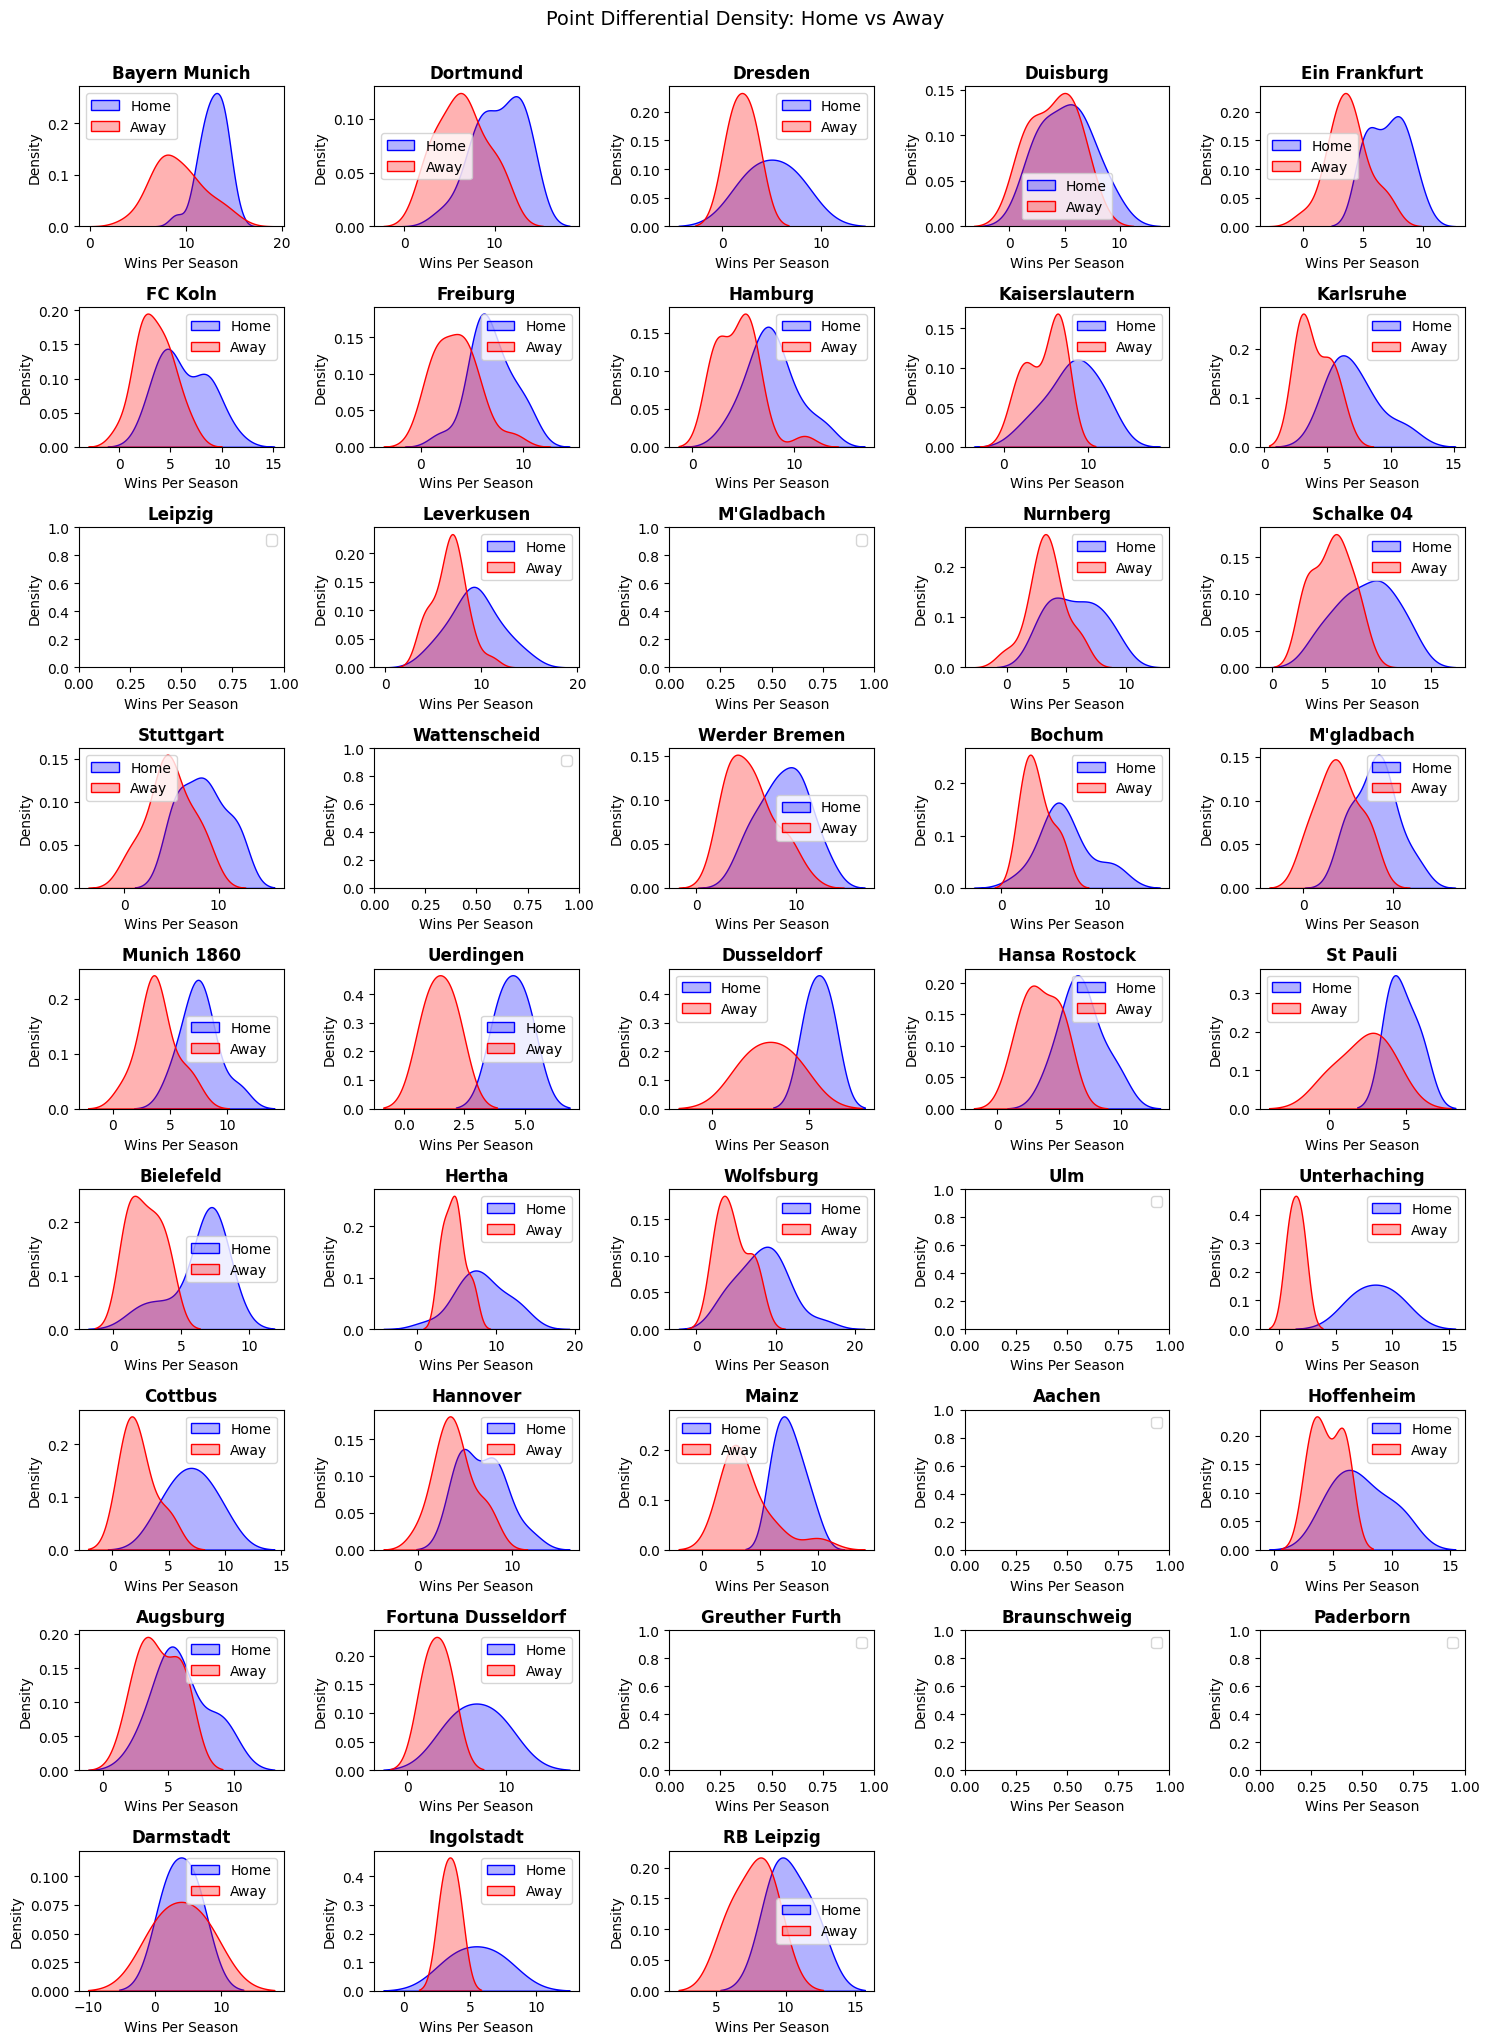

In [7]:
plt.figure(figsize=(15, 20))

for i, team in enumerate(win_counts['TEAM'].unique(), 1):
    ax = plt.subplot(9, 5, i)
    
    home_diffs = win_counts[win_counts['TEAM'] == team]['HOME_WIN']
    sns.kdeplot(home_diffs, color='blue', label='Home', fill=True, alpha=0.3, ax=ax)
    
    away_diffs = win_counts[win_counts['TEAM'] == team]['AWAY_WIN']
    sns.kdeplot(away_diffs, color='red', label='Away', fill=True, alpha=0.3, ax=ax)
    
    ax.set_title(f"{team}", fontweight='bold')
    ax.set(xlabel='Wins Per Season')
    ax.legend()

plt.tight_layout()
plt.suptitle("Point Differential Density: Home vs Away", y=1.02, fontsize=14)
plt.show()

The graphs show the density of wins per season. One for Home wins and one for Away wins. The empty graphs are due to the team not playing in that season or playing only one game. As we can see here also the distribution shows that teams tend to win more in home games.

# Part 3

### 1. Team Trajectories and Volatility
• Seasonal Position Trajectories \
• Line plots showing seasonal ranks for top 6 teams. \
• Annotate title-winning seasons.

In [8]:
df2 = pd.read_csv('bundesliga2.csv')
df2.head()

,TEAM,M,W,D,L,GF,GA,DIFF,POINTS,POSITION,SEASON
0,Bayern Munich,34,17,10,7,68,37,31,61,1,1994
1,Kaiserslautern,34,18,7,9,64,36,28,61,2,1994
2,Dortmund,34,15,9,10,49,45,4,54,3,1994
3,Ein Frankfurt,34,15,8,11,57,41,16,53,4,1994
4,Leverkusen,34,14,11,9,60,47,13,53,5,1994


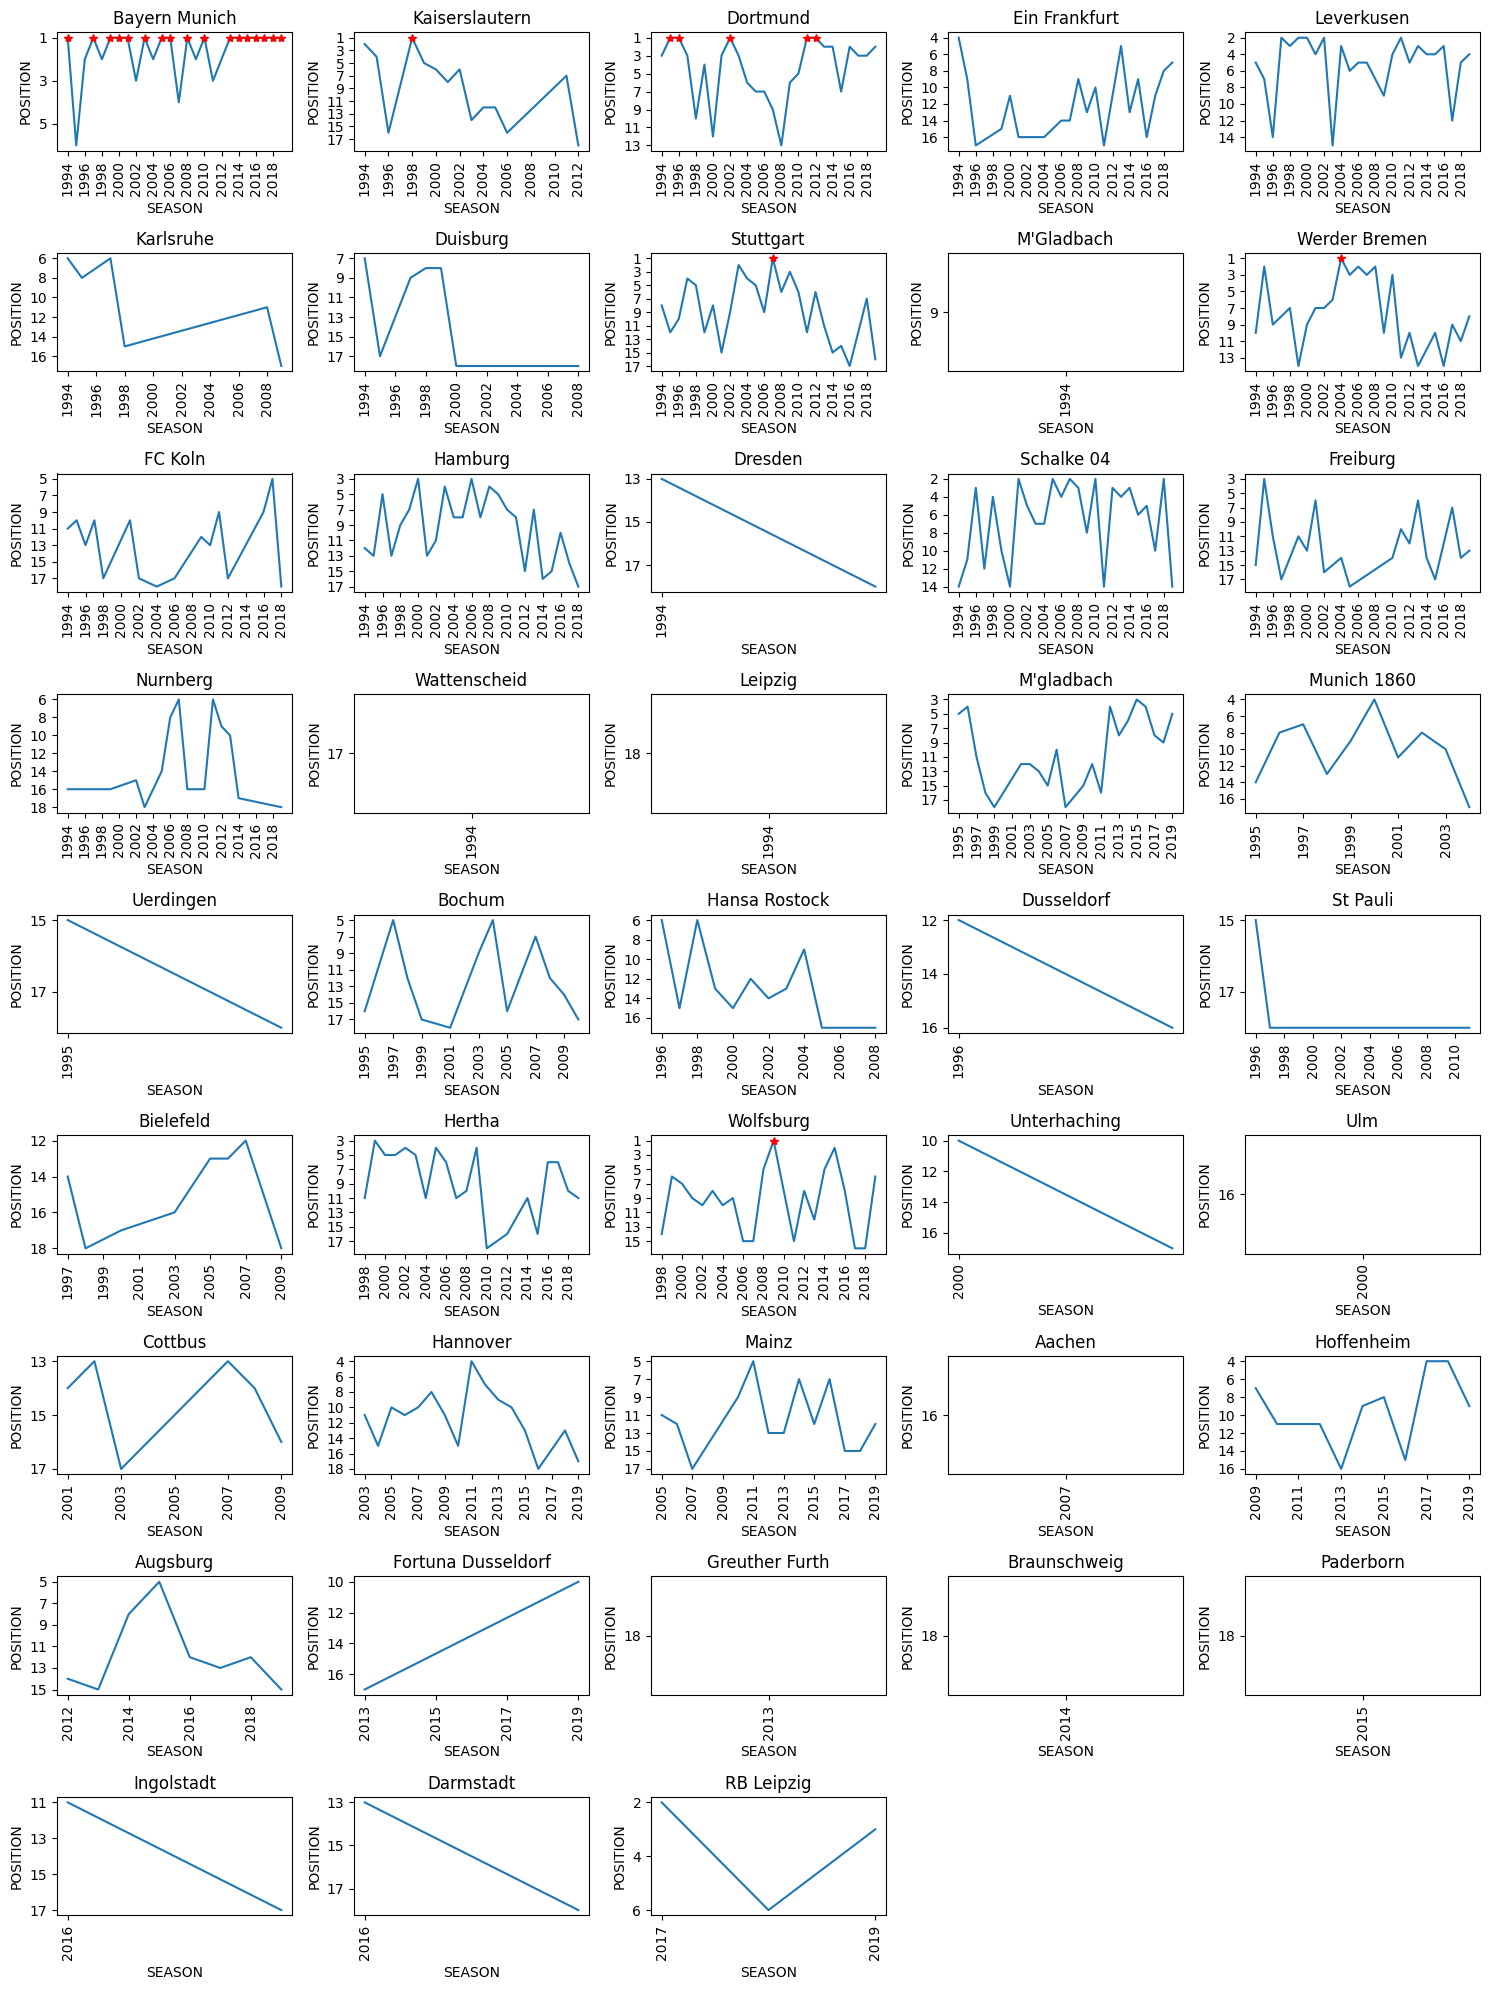

In [9]:
plt.figure(figsize=(15, 20))
for i, team in enumerate(df2['TEAM'].unique(), 1):
    subset = df2[df2['TEAM'] == team]
    ax = plt.subplot(9, 5, i)
    sns.lineplot(x='SEASON', y = 'POSITION', data=subset)
    first_place = subset[subset['POSITION'] == 1]
    ax.plot(first_place['SEASON'], first_place['POSITION'], '*', color='red')
    ax.set_yticks(range(min(subset['POSITION']), max(subset['POSITION'])+1, 2))
    ax.set_xticks(range(min(subset['SEASON']), max(subset['SEASON'])+1, 2))
    ax.set_title(team)
    ax.invert_yaxis()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

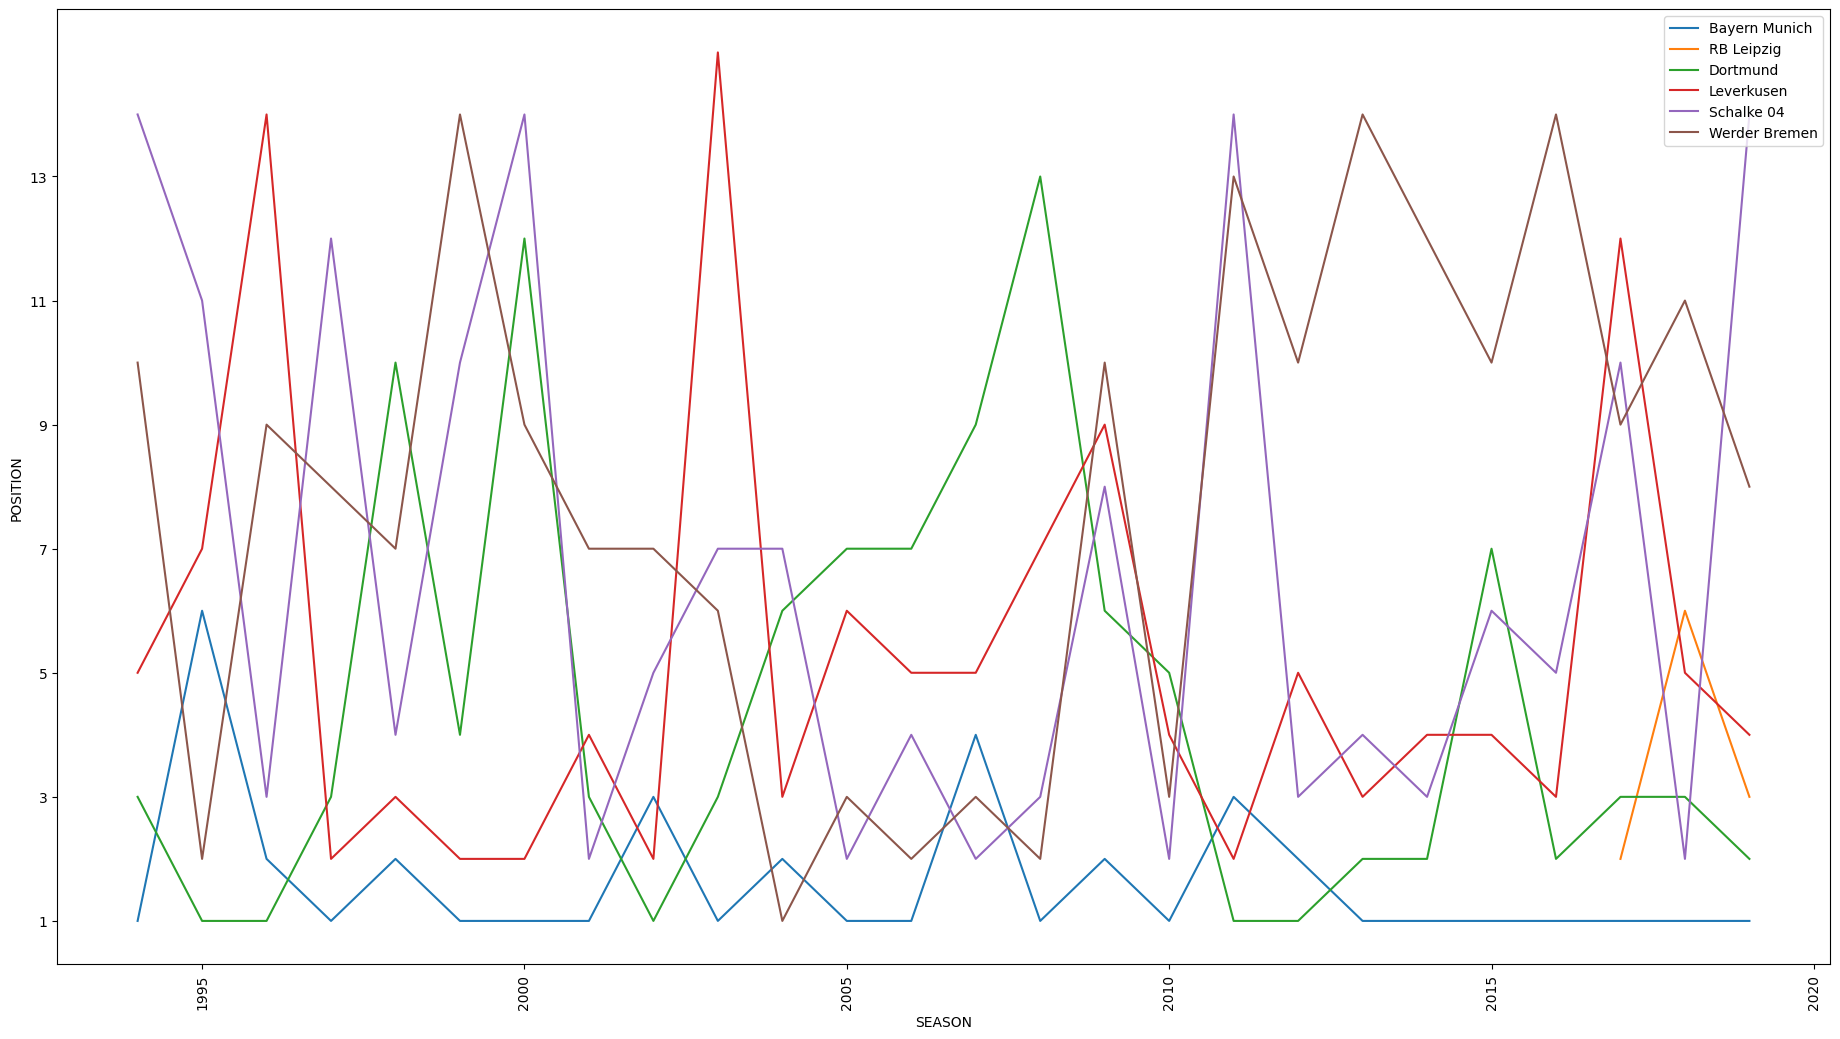

In [10]:
top_teams = list(df2.groupby('TEAM')['POSITION'].mean().sort_values().index[:6])
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
for team in top_teams:
    subset = df2[df2['TEAM'] == team]
    sns.lineplot(x='SEASON', y = 'POSITION', data=subset, label=team)
    ax.set_yticks(range(min(subset['POSITION']), max(subset['POSITION'])+1, 2))
    ax.invert_yaxis()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.legend(loc='upper right');

### 2. Volatility Index
• For each team, calculate standard deviation of final rank over all seasons. \
• Use a bar chart with conditional coloring (e.g., red = unstable, green = consistent). \
• Add text labels above each bar with exact values.

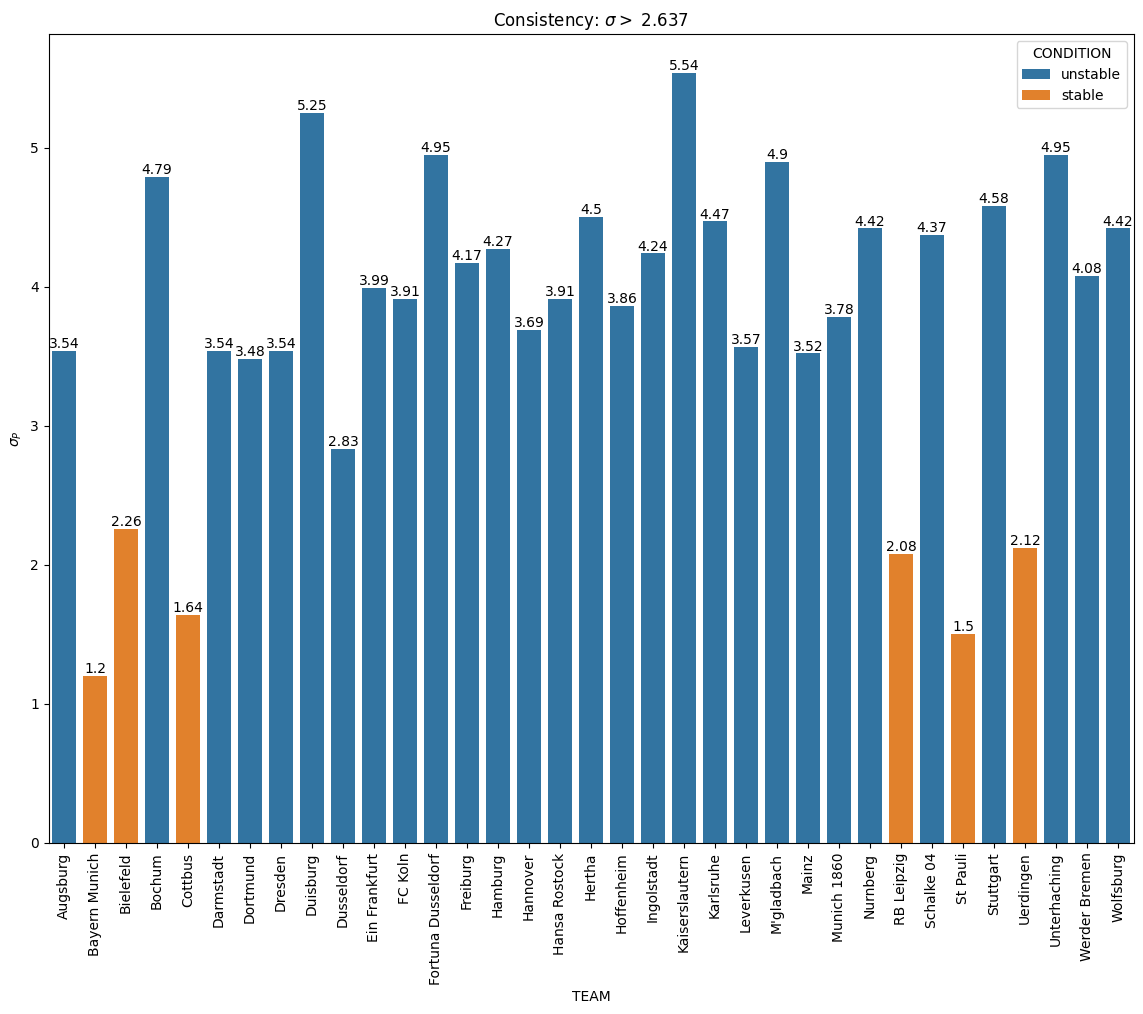

In [11]:
#We have some NaN-s but thats because some teams played only one season and we cant get their sd so we drop them.
team_sd = df2.groupby('TEAM')['POSITION'].std().dropna().reset_index()
threshold = team_sd['POSITION'].mean() * 0.70 # I am taking the 70% of the mean of sd-s as a threshold for the conditional coloring
team_sd['CONDITION'] = team_sd['POSITION'].apply(lambda x: 'unstable' if x > threshold else 'stable')
team_sd['POSITION'] = team_sd['POSITION'].apply(lambda x: float("%.2f" % x)) #For better visibility later
fig, ax = plt.subplots()
fig.set_size_inches(14, 10.5)
sns.barplot(x='TEAM', y='POSITION', hue='CONDITION', data=team_sd, ax=ax)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set_ylabel(f'$\sigma_P$')
ax.set_title(f'Consistency: $\sigma >$ {"%.3f" % threshold}')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

## Part 4: Rivalries & Big Match Patterns (R or Python)

### 1. Head-to-Head Matrix for Selected Rivalries
• Select 5 key rivalries more info click here. \
• Create a facet grid of win/draw/loss bar charts per rivalry. \
• Annotate biggest win margins.

Biggest rivalaries in Bundesliga:\
Bayern Munich - Borussia Dortmund\
Borussia Dortmund - Schalke\
Bayern Munich - Borussia Mönchengladbach\
Cologne - Borussia Mönchengladbach\
Hamburg - Werder Bremen

In [12]:
#This is what peak programming looks like
rivalry = df[(((df['HOMETEAM'] == 'Bayern Munich') & (df['AWAYTEAM'] == 'Dortmund')) | ((df['AWAYTEAM'] == 'Bayern Munich') & (df['HOMETEAM'] == 'Dortmund'))) | (((df['HOMETEAM'] == 'Dortmund') & (df['AWAYTEAM'] == 'Schalke 04')) | ((df['AWAYTEAM'] == 'Dortmund') & (df['HOMETEAM'] == 'Schalke 04'))) | (((df['HOMETEAM'] == 'Bayern Munich') & (df['AWAYTEAM'] == 'M\'gladbach')) | ((df['AWAYTEAM'] == 'Bayern Munich') & (df['HOMETEAM'] == 'M\'gladbach'))) | ((df['HOMETEAM'] == 'FC Koln') & (df['AWAYTEAM'] == 'M\'gladbach')) | ((df['AWAYTEAM'] == 'FC Koln') & (df['HOMETEAM'] == 'M\'gladbach')) | (((df['HOMETEAM'] == 'Hamburg') & (df['AWAYTEAM'] == 'Werder Bremen')) | ((df['AWAYTEAM'] == 'Hamburg') & (df['HOMETEAM'] == 'Werder Bremen')))]
rivalry.head()

,SEASON,LEAGUE,DATE,HOMETEAM,AWAYTEAM,FTSC,FTHG,FTAG,FTTG,HOME_WIN,AWAY_WIN
16,1994,Bundesliga 1,1993-08-14,Schalke 04,Dortmund,1-0,1,0,1,1,0
72,1994,Bundesliga 1,1993-09-25,Dortmund,Bayern Munich,1-1,1,1,2,0,0
116,1994,Bundesliga 1,1993-10-23,Werder Bremen,Hamburg,0-2,0,2,2,0,1
163,1994,Bundesliga 1,1993-12-04,Dortmund,Schalke 04,1-1,1,1,2,0,0
225,1994,Bundesliga 1,1994-03-19,Bayern Munich,Dortmund,0-0,0,0,0,0,0


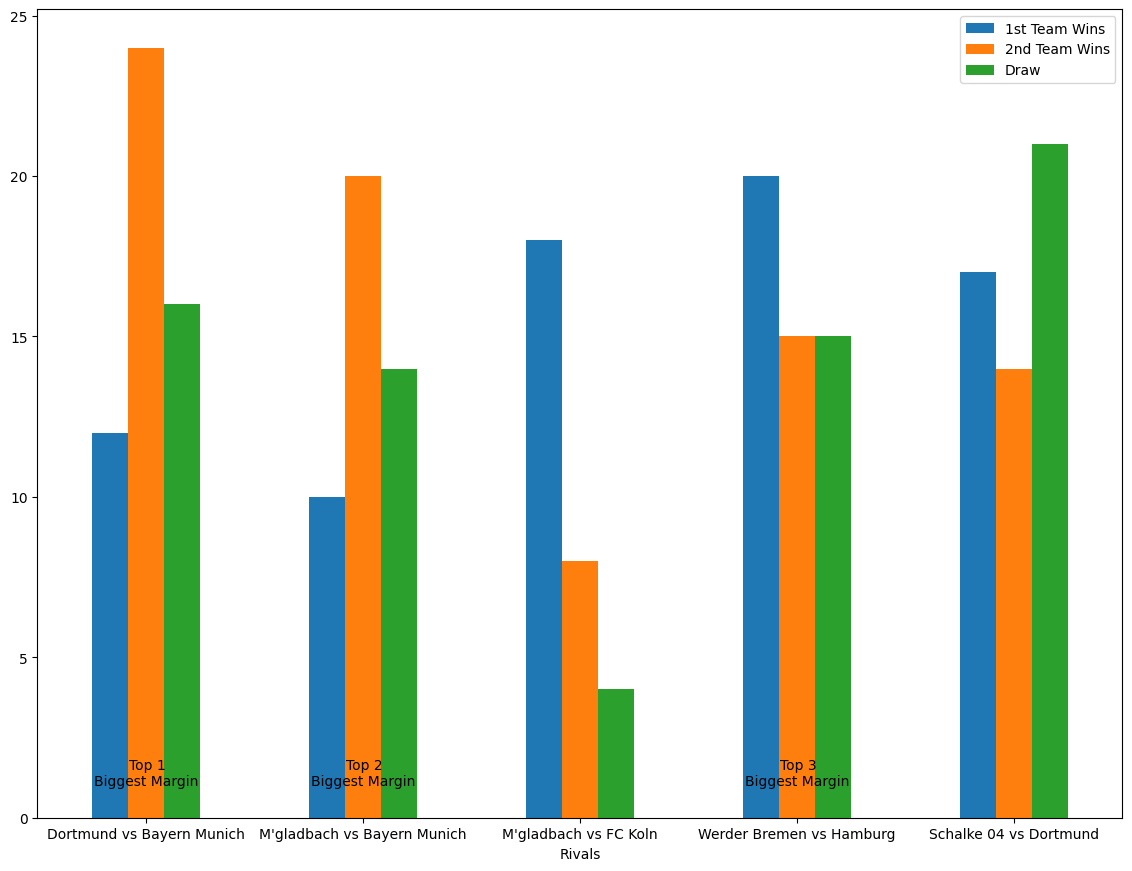

In [13]:
rivalry['DRAW'] = (rivalry['HOME_WIN'] == rivalry['AWAY_WIN']).astype(int)
home_wins = rivalry.groupby(['HOMETEAM', 'AWAYTEAM'])['HOME_WIN'].sum().reset_index()
away_wins = rivalry.groupby(['AWAYTEAM', 'HOMETEAM'])['AWAY_WIN'].sum().reset_index()

draws = rivalry.groupby(['AWAYTEAM', 'HOMETEAM'])['DRAW'].sum().reset_index()

home_wins.rename(columns={'HOMETEAM': 'TEAM1', 'AWAYTEAM': 'TEAM2'}, inplace=True)
away_wins.rename(columns={'AWAYTEAM': 'TEAM1', 'HOMETEAM': 'TEAM2'}, inplace=True)

draws.rename(columns={'HOMETEAM': 'TEAM1', 'AWAYTEAM': 'TEAM2'}, inplace=True)

win_counts = pd.merge(home_wins, away_wins, on=['TEAM1', 'TEAM2'], how='outer')

win_counts['TEAM1_WIN'] = win_counts['HOME_WIN'] + win_counts['AWAY_WIN']
win_counts = win_counts[['TEAM1', 'TEAM2', 'TEAM1_WIN']]

final = pd.merge(win_counts, draws, on=['TEAM1', 'TEAM2'], how='outer')

final_copy = final


pairs = np.array([(list(final_copy['TEAM1']), list(final_copy['TEAM2']))]).T

#Using loops for manipulating data in pandas is not a good practice, but i could not do it with built in functions
check = []
final_final = []
for pair in pairs:
    flag = False
    for i in check:
        if (i[0] == pair[0][0] and i[1] == pair[1][0]) or (i[1] == pair[0][0] and i[0] == pair[1][0]):
            flag = True
            break
    if flag:
        continue
    check.append([pair[0][0], pair[1][0]])
    tmp = final_copy[(final_copy['TEAM1'] == pair[1][0]) & (final_copy['TEAM2'] == pair[0][0])]
    tmp['TEAM2_WIN'] = int(final_copy[(final_copy['TEAM1'] == pair[0][0]) & (final_copy['TEAM2'] == pair[1][0])]['TEAM1_WIN'])
    tmp['DRAW'] = int(tmp['DRAW']) + int(final_copy[(final_copy['TEAM1'] == pair[0][0]) & (final_copy['TEAM2'] == pair[1][0])]['DRAW'])
    final_final.append(tmp)

final_final = pd.concat(final_final)
final_final.reset_index(inplace=True, drop=True)

final_final['Rivals'] = final_final['TEAM1'] + ' vs ' + final_final['TEAM2']
final_final = final_final[['Rivals', 'TEAM1_WIN', 'TEAM2_WIN', 'DRAW']]

final_final['MARGIN'] = np.abs(final_final['TEAM1_WIN'] - final_final['TEAM2_WIN'])
final_final.sort_values('MARGIN', ascending=False, inplace=True)
biggest_margins = final_final.head(3)

fig, ax = plt.subplots()
fig.set_size_inches(14, 10.5)
final_final.plot(x='Rivals', y=['TEAM1_WIN', 'TEAM2_WIN', 'DRAW'], kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


for index, pos in enumerate(biggest_margins.index):
    ax.text(pos - 0.24, 1,f'        Top {index + 1}\nBiggest Margin')


plt.legend(['1st Team Wins', '2nd Team Wins', 'Draw']);

### 2. Upset Visualizer
• Define “upset” as a team >8 places below beating a top-5 team. \
• Scatterplot of upsets: x-axis = rank difference, y-axis = goal difference.\
• Encode team colors; highlight and label famous upsets. \
Note you can define top 5 by most points, most scorred goals, less consided goals.


In [14]:
home_wins = df.groupby('HOMETEAM')['FTHG'].sum().reset_index()
away_wins = df.groupby('AWAYTEAM')['FTAG'].sum().reset_index()

home_wins.rename(columns={'HOMETEAM': 'TEAM'}, inplace=True)
away_wins.rename(columns={'AWAYTEAM': 'TEAM'}, inplace=True)


win_counts = pd.merge(home_wins, away_wins, on='TEAM', how='outer').fillna(0)

win_counts['GOALS'] = win_counts['FTHG'] + win_counts['FTAG']
win_counts = win_counts[['TEAM', 'GOALS']]

win_counts.sort_values('GOALS', ascending=False, inplace=True)

win_counts['RANK'] = np.arange(win_counts.shape[0])
ranks = win_counts[['TEAM','RANK']]
ranks.set_index('RANK', inplace=True)
ranks_dict = {y: x for x, y in ranks.to_dict()['TEAM'].items()} # To get ranks later
top_5 = win_counts.head()['TEAM'] #Top 5 teams who scored most goals
bellow_8 = win_counts.iloc[13:]['TEAM']
bellow_8

#We need to get all matches where it's top 5 vs bellow 8
filtered_df = df[(df['HOMETEAM'].apply(lambda x: x in list(top_5)) & df['AWAYTEAM'].apply(lambda x: x in list(bellow_8))) |  (df['AWAYTEAM'].apply(lambda x: x in list(top_5)) & df['HOMETEAM'].apply(lambda x: x in list(bellow_8)))]

#Teams where top 5 lost to a bellow 8
upset_matches = filtered_df[filtered_df.apply(lambda x: ((x['HOMETEAM'] in list(top_5)) and (x['AWAY_WIN'] == 1)) or ((x['AWAYTEAM'] in list(top_5)) and (x['HOME_WIN'] == 1)), axis=1)]


def filter_teams(row):
    if row['HOMETEAM'] in list(bellow_8):
        return {'TEAM': row['HOMETEAM'], 'VS': row['AWAYTEAM'], 'RANKDIFF': ranks_dict[row['HOMETEAM']] - ranks_dict[row['AWAYTEAM']], 'GOALDIFF': row['FTHG'] - row['FTAG']}
    return {'TEAM': row['AWAYTEAM'], 'VS': row['HOMETEAM'], 'RANKDIFF': ranks_dict[row['AWAYTEAM']] - ranks_dict[row['HOMETEAM']], 'GOALDIFF': row['FTAG'] - row['FTHG']}

final_df = pd.DataFrame(list(upset_matches.apply(filter_teams, axis=1)))
final_df.reset_index(inplace=True, drop=True)
final_df.head()

,TEAM,VS,RANKDIFF,GOALDIFF
0,Wattenscheid,Schalke 04,32,3
1,M'Gladbach,Schalke 04,31,1
2,Duisburg,Werder Bremen,21,4
3,Leipzig,Dortmund,38,1
4,Nurnberg,Schalke 04,13,1


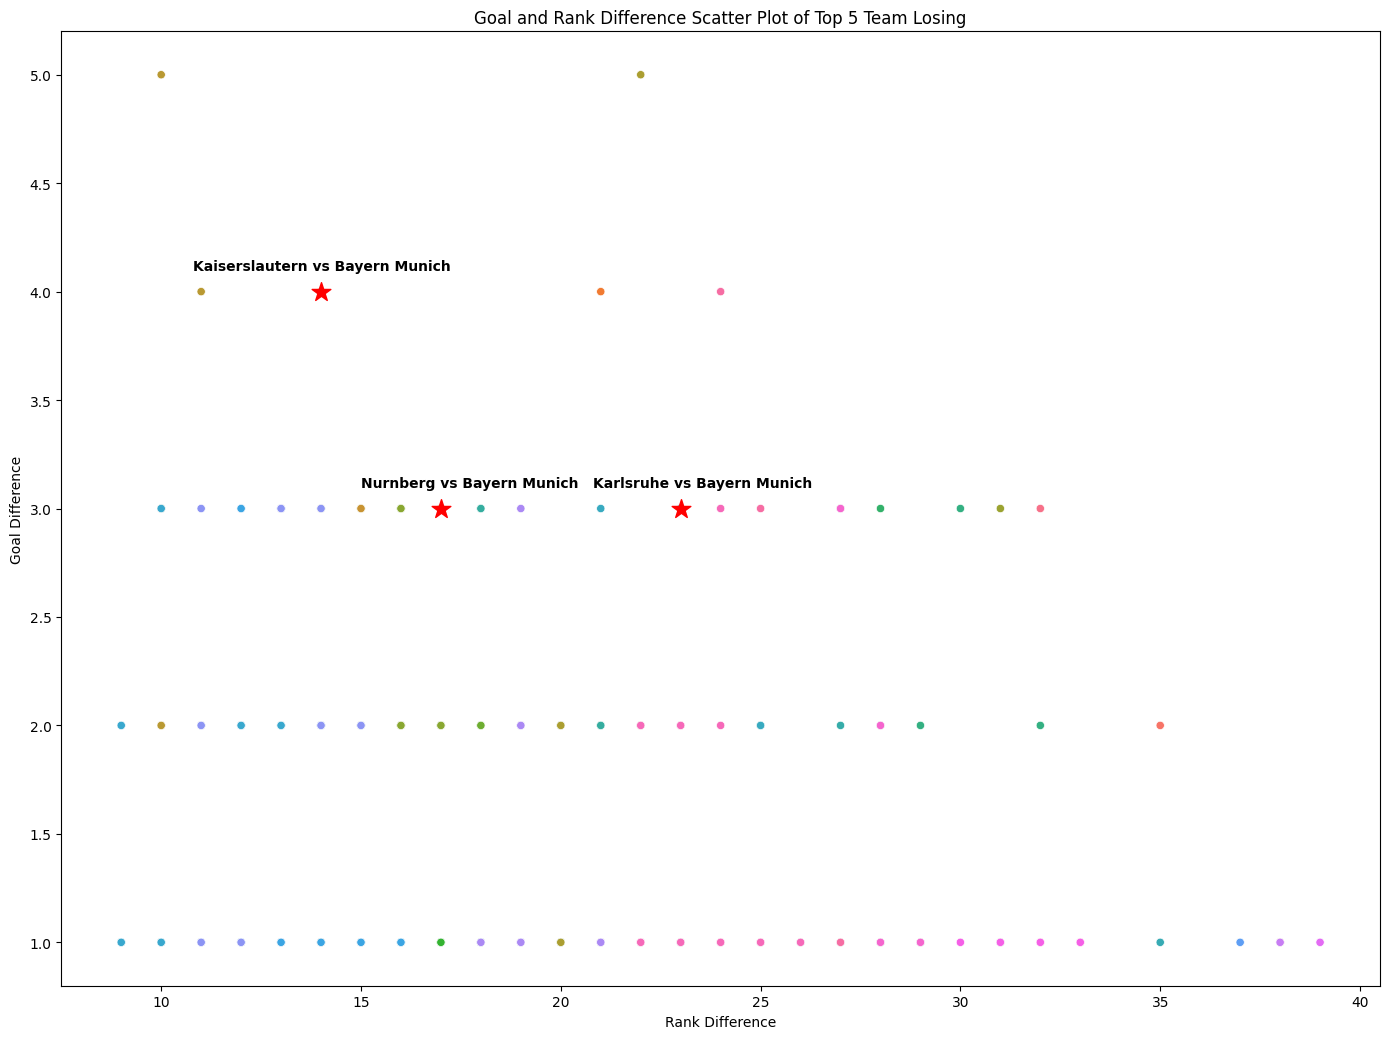

In [15]:
Munich_Losing = final_df[final_df['VS'] == 'Bayern Munich'].sort_values('GOALDIFF', ascending=False)[:3]
to_highlight = Munich_Losing.index

fig,ax = plt.subplots()
fig.set_size_inches(14, 10.5)
pl = sns.scatterplot(x='RANKDIFF', y='GOALDIFF', hue='TEAM', data=final_df, legend=False, ax=ax);
ax.set(xlabel='Rank Difference', ylabel='Goal Difference', title='Goal and Rank Difference Scatter Plot of Top 5 Team Losing')
ax.scatter(Munich_Losing['RANKDIFF'], Munich_Losing['GOALDIFF'], marker='*', color='red', s=200)



for line in to_highlight:
     pl.text(final_df['RANKDIFF'][line] - (len(str(final_df['TEAM'][line])) + 4) / 5 + 0.4, final_df['GOALDIFF'][line]+0.1, 
     f'{final_df['TEAM'][line]} vs {final_df['VS'][line]}', horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

plt.tight_layout()
plt.show()


## Part 5: Overall performance

### Redo the same task in python. But instead of total points use goal difference. Use same logic for colors as in first part.

In [16]:
pdf_filename = 'goal_difference_per_season.pdf'

def map_color(df, col):
    tmp = df.copy()
    color_d = dict(zip(tmp[col].unique(), sns.color_palette("hls", tmp[col].nunique())))
    tmp['color'] = tmp[col].map(color_d)
    return tmp

new_df2 = map_color(df2, 'TEAM')

with PdfPages(pdf_filename) as pdf:
    for season in new_df2['SEASON'].unique():
        fig, ax = plt.subplots()
        fig.set_size_inches(14, 10.5)
        subset = new_df2[new_df2['SEASON'] == season]
        subset.sort_values('DIFF', ascending=False, inplace=True)
        subset.at[subset.index[0], 'color'] = (0,0,0)
        subset = subset.sample(frac=1).reset_index(drop=True) #Shuffling so that the winner is in random places
        subset.plot.barh(x='TEAM', y='DIFF', ax=ax, color=subset.color.tolist(), legend = False)      
        ax.set_title(f'{season}', fontsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylabel('Goal Difference')
        plt.figtext(0.65, 0.01, f'Winner is highlighted with the Black color')
        pdf.savefig()
        plt.close()


print(f"PDF file '{pdf_filename}' has been created successfully!")

PDF file 'goal_difference_per_season.pdf' has been created successfully!


## Part 6. Monte Carlo simulation. (R or Python)

In [69]:
import numpy as np
import pandas as pd

teams = ['Bayern Munich', 'Leverkusen', 'Dortmund']
for team in teams:
    monte_df = df2.copy()
    avg = monte_df.groupby('TEAM')['GF'].mean()[team]
    std_dev = monte_df.groupby('TEAM')['GF'].std()[team]
    curr = monte_df[(monte_df['TEAM'] == team) & (monte_df['SEASON'] == monte_df['SEASON'].max())]['GF']
    curr = curr.iloc[0]
    monte_df = monte_df[['TEAM', 'SEASON', 'GF']]
    
    preds = []
    for _ in range(10):
        tmp = monte_df[(monte_df['TEAM'] == team) & (monte_df['SEASON'] == monte_df['SEASON'].max())].copy()
        random_shock = np.random.normal(loc=0, scale=std_dev)  
        tmp['GF'] = curr + random_shock 
        tmp['SEASON'] = tmp['SEASON'] + 1
        curr = tmp['GF'].values[0]
        preds.append(tmp)
        monte_df = pd.concat([monte_df, tmp], ignore_index=True)

    result_df = pd.concat(preds, ignore_index=True)
    display(result_df)


,TEAM,SEASON,GF
0,Bayern Munich,2020,64.561127
1,Bayern Munich,2021,75.980957
2,Bayern Munich,2022,90.718704
3,Bayern Munich,2023,76.641379
4,Bayern Munich,2024,64.771439
5,Bayern Munich,2025,59.625666
6,Bayern Munich,2026,54.595573
7,Bayern Munich,2027,41.728528
8,Bayern Munich,2028,68.161017
9,Bayern Munich,2029,55.000031


,TEAM,SEASON,GF
0,Leverkusen,2020,65.843782
1,Leverkusen,2021,66.555360
2,Leverkusen,2022,49.781216
3,Leverkusen,2023,39.633835
4,Leverkusen,2024,42.599532
5,Leverkusen,2025,37.189307
6,Leverkusen,2026,30.691282
7,Leverkusen,2027,32.738095
8,Leverkusen,2028,38.162937
9,Leverkusen,2029,32.157760


,TEAM,SEASON,GF
0,Dortmund,2020,83.826472
1,Dortmund,2021,75.045125
2,Dortmund,2022,96.343163
3,Dortmund,2023,109.137432
4,Dortmund,2024,92.974632
5,Dortmund,2025,73.460404
6,Dortmund,2026,63.899554
7,Dortmund,2027,41.947228
8,Dortmund,2028,28.550022
9,Dortmund,2029,35.727733
